In [1]:
import numpy
# scipy.special for the sigmoid function expit() and inverse sigmoid logit()
import scipy.special
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class NeuralNetwork:
    # initialize needed data
    def __init__(self,input_nodes,hidden_nodes,output_nodes,learning_rate):
        # set number of nodes in input, hidden and output layers
        self.inodes = input_nodes
        self.hnodes = hidden_nodes
        self.onodes = output_nodes
        
        # initialize weight matrices
        # input->hidden
        #self.wih = numpy.random.rand(self.hnodes,self.inodes)-0.5
        # center, stardard deviation 1/sqrt(number of links to each node of incoming layer)
        self.wih = numpy.random.normal(0.0,pow(self.inodes,-0.5),(self.hnodes,self.inodes)) 
        # hidden->output
        # self.who = numpy.random.rand(self.onodes,self.hnodes)-0.5
        self.who = numpy.random.normal(0.0,pow(self.hnodes,-0.5),(self.onodes,self.hnodes))
        
        # activation function is the sigmoid function
        self.activation_function = lambda x: scipy.special.expit(x)
        self.inverse_activation_function = lambda x: scipy.special.logit(x)
        # learning rate
        self.lr = learning_rate
        pass
    
    # refine the weights 
    def train(self,inputs_list,targets_list):
        # convert inputs_list to 2d array
        inputs = numpy.array(inputs_list,ndmin=2).T
        targets = numpy.array(targets_list,ndmin=2).T
        
        # calcualte signal into hidden layer
        hidden_inputs = numpy.dot(self.wih,inputs)
        # calculate outputs from hidden layer
        hidden_outputs = self.activation_function(hidden_inputs)
        
        final_inputs = numpy.dot(self.who,hidden_outputs)
        final_outputs = self.activation_function(final_inputs)
        
        # errors
        output_errors = targets - final_outputs
        
        # calculate errors for hidden nodes e_hidden = who.T * e_out 
        hidden_errors = numpy.dot(self.who.T, output_errors)
        
        #update weights between the hidden and output layers
        # new = old - lr * de/dwij
        self.who += self.lr * numpy.dot((output_errors * final_outputs * (1 - final_outputs)),numpy.transpose(hidden_outputs))
        #update weights between the input and hidden layers
        self.wih += self.lr * numpy.dot((hidden_errors * hidden_outputs * (1 - hidden_outputs)),numpy.transpose(inputs))
        pass
    
    # get answer from output nodes
    def query(self,inputs_list):
        # convert inputs_list to 2d array
        inputs = numpy.array(inputs_list,ndmin=2).T
        
         # calculate signals into hidden layer -> X = WIH * I
        hidden_inputs = numpy.dot(self.wih,inputs)
         # calculate the signals emerging from hidden layer -> O = activation_function(hidden_inputs)
        hidden_outputs = self.activation_function(hidden_inputs)
        
        final_inputs = numpy.dot(self.who,hidden_outputs)
        final_outputs = self.activation_function(final_inputs)
        
        return final_outputs
    
    # backquery the neural network
    # we'll use the same termnimology to each item, 
    # eg target are the values at the right of the network, albeit used as input
    # eg hidden_output is the signal to the right of the middle nodes
    def backquery(self, targets_list):
        # transpose the targets list to a vertical array
        final_outputs = numpy.array(targets_list, ndmin=2).T
        
        # calculate the signal into the final output layer
        final_inputs = self.inverse_activation_function(final_outputs)

        # calculate the signal out of the hidden layer
        hidden_outputs = numpy.dot(self.who.T, final_inputs)
        # scale them back to 0.01 to .99
        hidden_outputs -= numpy.min(hidden_outputs)
        hidden_outputs /= numpy.max(hidden_outputs)
        hidden_outputs *= 0.98
        hidden_outputs += 0.01
        
        # calculate the signal into the hidden layer
        hidden_inputs = self.inverse_activation_function(hidden_outputs)
        
        # calculate the signal out of the input layer
        inputs = numpy.dot(self.wih.T, hidden_inputs)
        # scale them back to 0.01 to .99
        inputs -= numpy.min(inputs)
        inputs /= numpy.max(inputs)
        inputs *= 0.98
        inputs += 0.01
        
        return inputs

In [4]:
##### Also possible to variate activation functions and scaling
# values for input, hidden and output nodes
input_nodes = 784
hidden_nodes = 200  ##### Change
output_nodes = 10

# learning rate
learning_rate = 0.1 ##### Change

# instanse of neural network
n = NeuralNetwork(input_nodes,hidden_nodes,output_nodes,learning_rate)

In [124]:
# load the MINST training data file into a list
training_data_file = open("mnist dataset/mnist_train.csv",'r')
training_data_list = training_data_file.readlines()
training_data_file.close()

In [127]:
# train the neural network
import scipy.ndimage.interpolation
for epochs in range(0,10):  ##### Change
    for record in training_data_list:
        all_values = record.split(',')
        inputs = (numpy.asfarray(all_values[1:])/255*0.99)+0.01
        targets = numpy.zeros(output_nodes)+0.01
        targets[int(all_values[0])]=0.99
        
        targets_plus_10 = scipy.ndimage.interpolation.rotate(inputs.reshape(28,28),10,cval=0.01,reshape=False)
        targets_minus_10 = scipy.ndimage.interpolation.rotate(inputs.reshape(28,28),-10,cval=0.01,reshape=False)
        
        n.train(inputs,targets)
        n.train(targets_plus_10.reshape(784),targets)
        n.train(targets_minus_10.reshape(784),targets)
        pass
    pass
print("Ended training")

Ended training


In [128]:
# test the neural network!
testing_data_file = open("mnist dataset/mnist_test.csv",'r')
testing_list = testing_data_file.readlines()
testing_data_file.close()

scorecard=[]
for testing_record in testing_list:
    testing_inputs = testing_record.split(',')

    testing_list = (numpy.asfarray(testing_inputs[1:])/255*0.99)+0.01
    result=n.query(testing_list)
    index=numpy.argmax(result)
    if (index==int(testing_inputs[0])):
        scorecard.append(1)
    else:
        scorecard.append(0)
        pass
    pass
scorecard_array=numpy.asarray(scorecard)
print("Performance: ",scorecard_array.sum()/scorecard_array.size)

Performance:  0.9676


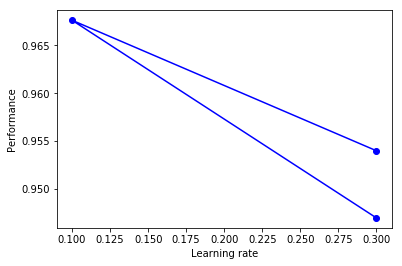

In [145]:
plt.plot([0.3,0.1,0.3],[0.947,0.9676,0.954],'bo-')
plt.axis([0,0.7,0,1])
plt.ylabel('Performance')
plt.xlabel('Learning rate')
plt.show()

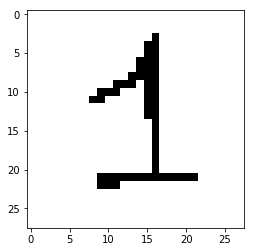

NameError: name 'n' is not defined

In [3]:
# train on my own input data
import scipy.misc
img_array = scipy.misc.imread("test_1.png",flatten=True)

img_list = 255.0 - img_array.reshape(784)
img_list = (img_list/255 * 0.99)+0.01
plt.imshow(img_list.reshape(28,28),cmap='Greys',interpolation='None')
plt.show()


result = numpy.argmax(n.query(img_list))
print(result)

[ 0.01  0.01  0.01  0.99  0.01  0.01  0.01  0.01  0.01  0.01]


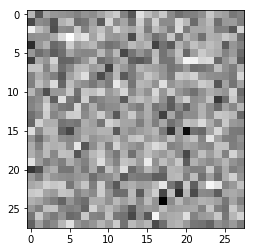

In [5]:
input_list = numpy.zeros(10)+0.01
input_list[3]=0.99
print(input_list)
res_image = n.backquery(input_list)
plt.imshow(res_image.reshape(28,28),cmap='Greys',interpolation='None')
plt.show()


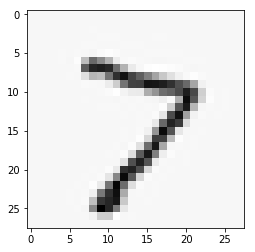

In [142]:
import scipy.ndimage.interpolation
testing_data_file = open("mnist dataset/mnist_test.csv",'r')
testing_list = testing_data_file.readlines()
testing_data_file.close()

testing_inputs = testing_list[0].split(',')
testing_list = (numpy.asfarray(testing_inputs[1:])/255*0.99)+0.01
plus_10 = scipy.ndimage.interpolation.rotate(testing_list.reshape(28,28),10,cval=0.01,reshape=False)
minus_10 = scipy.ndimage.interpolation.rotate(testing_list.reshape(28,28),-10,cval=0.01,reshape=False)
plt.imshow(plus_10,cmap='Greys',interpolation='None')
pls.imshow(minus_10,cmap='Greys',interpolation='None')
plt.show()